In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

dataset = fetch_openml(data_id=44226, as_frame=True, parser='auto')
df = dataset.frame
print(df.head())

   SubscriptionID            HH Income Home Ownership Ethnicity  \
0       180590686  $  30,000 - $39,999         RENTER    German   
1       181401653        $500,000 Plus          OWNER   unknown   
2       180374685  $100,000 - $124,999          OWNER   Italian   
3       180703483  $200,000 - $249,999          OWNER   English   
4       180358906  $  50,000 - $59,999          OWNER   Italian   

  dummy for Children  Year Of Residence Age range Language            Address  \
0                  N                  1     25-29   German  1 3RD PL UNIT 703   
1                  Y                 14     50-54      NaN          1 AVIGNON   
2                  Y                  7     45-49  English        1 BLACKSWAN   
3                  N                 23     55-59  English     1 BLUE HORIZON   
4                  N                 23     60-64  English   1 BRISA DEL LAGO   

  State                    City       County  Zip Code     weekly fee  \
0    CA              LONG BEACH  LOS 

# STEP 1 - EDA

## STEP 1.1 - ANALYZING DATA

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SubscriptionID      15855 non-null  int64 
 1   HH Income           15855 non-null  object
 2   Home Ownership      15855 non-null  object
 3   Ethnicity           15855 non-null  object
 4   dummy for Children  15855 non-null  object
 5   Year Of Residence   15855 non-null  int64 
 6   Age range           15747 non-null  object
 7   Language            14848 non-null  object
 8   Address             15855 non-null  object
 9   State               15855 non-null  object
 10  City                15855 non-null  object
 11  County              15855 non-null  object
 12  Zip Code            15855 non-null  int64 
 13  weekly fee          15669 non-null  object
 14  Deliveryperiod      15855 non-null  object
 15  Nielsen Prizm       15726 non-null  object
 16  reward program      15

In [3]:
print(df.isna().sum())

SubscriptionID           0
HH Income                0
Home Ownership           0
Ethnicity                0
dummy for Children       0
Year Of Residence        0
Age range              108
Language              1007
Address                  0
State                    0
City                     0
County                   0
Zip Code                 0
weekly fee             186
Deliveryperiod           0
Nielsen Prizm          129
reward program           0
Source Channel           0
Subscriber               0
dtype: int64


#### We can see that some columns contain nulls. I will handle them later when processing these columns.

In [4]:
print(df["Home Ownership"].unique())
print(df["dummy for Children"].unique())
print(df["Language"].unique())
print(df["State"].unique())
print(df["City"].unique())
print(df["Subscriber"].unique())

['RENTER' 'OWNER']
['N' 'Y']
['German' nan 'English' 'Italian' 'Chinese' 'Spanish' 'Vietnamese'
 'Farsi (Persian)' 'Japanese' 'Turkish' 'Polish' 'Russian' 'Portuguese'
 'Hebrew' 'Hindi' 'Arabic' 'Korean' 'Urdu' 'Czech' 'Romanian' 'Thai'
 'Khmer (Cambodian)' 'Danish' 'Amharic' 'Laotian (Lao)' 'Swedish'
 'Tagalog' 'French' 'Armenian' 'Norwegian' 'Hungarian' 'Finnish' 'Ga'
 'Slovenian' 'Dutch' 'Serbo-Croatian' 'Greek' 'Latvian (Lettish)']
['CA']
['LONG BEACH' 'NEWPORT COAST' 'IRVINE' 'LAGUNA NIGUEL'
 'RANCHO SANTA MARGARITA' 'LADERA RANCH' 'SAN CLEMENTE' 'BUENA PARK'
 'ALISO VIEJO' 'LAGUNA WOODS' 'NEWPORT BEACH' 'FOOTHILL RANCH'
 'TRABUCO CANYON' 'DANA POINT' 'LAGUNA HILLS' 'LAGUNA BEACH' 'ANAHEIM'
 'SANTA ANA' 'FULLERTON' 'LA HABRA' 'COSTA MESA' 'PLACENTIA'
 'HUNTINGTON BEACH' 'CYPRESS' 'GARDEN GROVE' 'CORONA' 'BREA' 'WESTMINSTER'
 'WHITTIER' 'FOUNTAIN VALLEY' 'VILLA PARK' 'ORANGE' 'TUSTIN' 'STANTON'
 'NORCO' 'DIAMOND BAR' 'LOS ALAMITOS' 'MISSION VIEJO' 'CERRITOS'
 'CORONA DEL MAR' 'SEAL

#### There's only one state "CA" everywhere, so we can get rid of it easily. Home ownership, dummy for Children and Subscriber (our future target) are easy to encode already, so I will do this right now. 

In [5]:
Y_N_mapping = {"Y": 1, "N": 0, "YES": 1, "NO": 0}
df["Children"] = df["dummy for Children"].map(Y_N_mapping)
df["Target"] = df["Subscriber"].map(Y_N_mapping)
df["Owns a House"] = df["Home Ownership"].map({"RENTER": 0, "OWNER": 1})

#### Now it is time to drop some unnecessary columns.
#### dummy for children, Home ownership, Subscriber - we already processed these
#### State - one for every data, no need to use this
#### City, Ethnicity - too many cases
#### Adress, SubscriptionID, ZipCode, - Personal unnecesary data (would cause only noise)

In [6]:
df = df.drop(columns=["dummy for Children", "Home Ownership", "State", "Subscriber", "City", "Address", "SubscriptionID", "Ethnicity", "Zip Code"])

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   HH Income          15855 non-null  object
 1   Year Of Residence  15855 non-null  int64 
 2   Age range          15747 non-null  object
 3   Language           14848 non-null  object
 4   County             15855 non-null  object
 5   weekly fee         15669 non-null  object
 6   Deliveryperiod     15855 non-null  object
 7   Nielsen Prizm      15726 non-null  object
 8   reward program     15855 non-null  int64 
 9   Source Channel     15855 non-null  object
 10  Children           15855 non-null  int64 
 11  Target             15855 non-null  int64 
 12  Owns a House       15855 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 1.6+ MB


# STAGE 1.2 - PROCESSING CHOSEN DATA

In [8]:
df["Language"].value_counts()

Language
English              11005
Spanish               2609
Vietnamese             401
Chinese                161
Korean                 113
Portuguese             101
Hindi                   88
Arabic                  69
Italian                 56
Japanese                55
Farsi (Persian)         45
German                  25
Romanian                15
Hebrew                  15
Polish                   9
French                   9
Russian                  7
Armenian                 7
Tagalog                  6
Danish                   5
Swedish                  5
Dutch                    5
Hungarian                5
Thai                     4
Khmer (Cambodian)        4
Amharic                  3
Urdu                     3
Slovenian                2
Greek                    2
Serbo-Croatian           2
Norwegian                2
Finnish                  2
Czech                    2
Laotian (Lao)            2
Latvian (Lettish)        2
Ga                       1
Turkish            

In [9]:
def process_language(lang):
    lang = str(lang).strip()
    if "English" in lang:
        return "English"
    elif "Spanish" in lang:
        return "Spanish"
    else:
        return "Other/NoData"

df["Language"] = df["Language"].apply(process_language)
df = pd.get_dummies(df,columns=["Language"],drop_first=True,dtype=int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   HH Income              15855 non-null  object
 1   Year Of Residence      15855 non-null  int64 
 2   Age range              15747 non-null  object
 3   County                 15855 non-null  object
 4   weekly fee             15669 non-null  object
 5   Deliveryperiod         15855 non-null  object
 6   Nielsen Prizm          15726 non-null  object
 7   reward program         15855 non-null  int64 
 8   Source Channel         15855 non-null  object
 9   Children               15855 non-null  int64 
 10  Target                 15855 non-null  int64 
 11  Owns a House           15855 non-null  int64 
 12  Language_Other/NoData  15855 non-null  int32 
 13  Language_Spanish       15855 non-null  int32 
dtypes: int32(2), int64(5), object(7)
memory usage: 1.6+ MB


In [11]:
print(df.isna().sum())

HH Income                  0
Year Of Residence          0
Age range                108
County                     0
weekly fee               186
Deliveryperiod             0
Nielsen Prizm            129
reward program             0
Source Channel             0
Children                   0
Target                     0
Owns a House               0
Language_Other/NoData      0
Language_Spanish           0
dtype: int64


#### After processing "Language", I will remove rows with no data, because worst case scenario, there are 423 of them, which is roughly 2,7% of our data

In [12]:
z = (108+186+129)/15855 #worst case scenario that every NA is in a different row
print(z*100)
df = df.dropna().reset_index(drop=True) 

2.6679280983916747


#### Cleaning numerical columns to be able to use them for our LDA model later

In [13]:
df["weekly fee"].unique()

array(['$7.00 - $7.99', '$0.01 - $0.50', '$1.00 - $1.99', '$8.00 - $8.99',
       '$0 - $0.01', '$2.00 - $2.99', '$9.00 - $9.99', '$4.00 - $4.99',
       '$0.51 - $0.99', '$3.00 - $3.99', '$5.00 - $5.99', '$6.00 - $6.99',
       '$10.00 - $10.99', '$0'], dtype=object)

In [14]:
def process_income(val):
    if pd.isna(val):
        return np.nan
    val_string = str(val).replace("$", "").replace(",","").strip()
    if "Under" in val_string:
        number = val_string.replace("Under","").strip()
        return float(number)/2
    elif "Plus" in val_string:
        number = val_string.replace("Plus","").strip()
        return float(number)
    elif "-" in val_string:
        left_val = float(val_string.split("-")[0].strip())
        right_val = float(val_string.split("-")[1].strip())
        return (left_val+right_val)/2 if (left_val+right_val)/2>0.01 else 0.01
    return 0

df["HH Income"] = df["HH Income"].apply(process_income).round()
df["weekly fee"] = df["weekly fee"].apply(process_income).round(2)
print(df["HH Income"])
print(df["weekly fee"])
print(df["HH Income"].unique())
print(df["weekly fee"].unique())

0         35000.0
1        500000.0
2        112500.0
3        225000.0
4         55000.0
           ...   
15433     25000.0
15434     85000.0
15435     85000.0
15436    162500.0
15437    187500.0
Name: HH Income, Length: 15438, dtype: float64
0        7.50
1        0.26
2        0.26
3        1.50
4        8.50
         ... 
15433    0.26
15434    0.26
15435    0.01
15436    1.50
15437    0.26
Name: weekly fee, Length: 15438, dtype: float64
[ 35000. 500000. 112500. 225000.  55000. 162500. 450000. 187500. 137500.
  10000.  85000.  95000. 350000.  25000.  75000.  65000.  45000. 275000.]
[7.50e+00 2.60e-01 1.50e+00 8.50e+00 1.00e-02 2.50e+00 9.50e+00 4.50e+00
 7.50e-01 3.50e+00 5.50e+00 6.50e+00 1.05e+01 0.00e+00]


In [15]:
df["Age range"].unique()

array(['25-29', '50-54', '45-49', '55-59', '60-64', '75 years or more',
       '65-69', '70-74', '40-44', '24 years or less', '35-39', '30-34'],
      dtype=object)

In [16]:
def process_age(range):
    if pd.isna(range):
        return np.nan
    range_string = str(range).lower().strip()
    if "years" in range_string:
        return float(range_string[0:2])
    elif "-" in range_string:
        left_val = float(range_string.split("-")[0].strip())
        right_val = float(range_string.split("-")[1].strip())
        return (left_val+right_val)/2
    return np.nan

In [17]:
df["Age range"] = df["Age range"].apply(process_age)

In [18]:
df = df.rename(columns={"Age range": "Age"})
df.head()

,HH Income,Year Of Residence,Age,County,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Children,Target,Owns a House,Language_Other/NoData,Language_Spanish
0,35000.0,1,27.0,LOS ANGELES,7.50,7Day,FM,0,CircAdm,0,0,0,1,0
1,500000.0,14,52.0,ORANGE,0.26,SunOnly,MW,0,Partner,1,1,1,1,0
2,112500.0,7,47.0,ORANGE,0.26,SunOnly,MW,0,Partner,1,1,1,0,0
3,225000.0,23,57.0,ORANGE,1.50,SunOnly,MW,1,Internet,0,0,1,0,0
4,55000.0,23,62.0,ORANGE,8.50,Thu-Sun,MM,0,Crew,0,1,1,0,0


#### One-hot Encoding non-numerical data

In [19]:
df["Deliveryperiod"].unique()

array(['7Day', 'SunOnly', 'Thu-Sun', 'SatSun', '7DayOL', 'SoooooS',
       'THU-SUN', 'Mon-Fri', '7DAY', 'SooooFS', 'SooooooT', '7DayT',
       'Fri-Sun', 'SoooTFS', 'SunOnlyT', 'Soooooo', 'Thu-SunT', 'oMTWTFo',
       'Fri-SunT', 'SoooTFST', 'Sun-Fri', 'sunonly', 'SoooooST', '7day',
       'Sun-FriT', 'SUNONLY', 'thu-sun', 'SooooFST'], dtype=object)

In [20]:
correct_names = {"7day": "7Day", "SUNONLY": "SunOnly", "oMTWTFo": "Mon-Fri", "7DayOL": "7Day",
                  "SoooooS": "SatSun", "SunOnlyT": "SunOnly", "SoooooST": "SatSun", "thu-sun":"Thu-Sun", "Sun-FriT":"Sun-Fri",
                  "7DAY": "7Day", "SooooFS": "Fri-Sun", "THU-SUN": "Thu-Sun", "7DayT": "7Day", "sunonly":"SunOnly",
                  "SooooooT": "SunOnly", "SoooTFST": "Thu-Sun", "Fri-SunT": "Fri-Sun", "Thu-SunT":"Thu-Sun",
                  "SoooTFS": "Thu-Sun", "Soooooo":"SunOnly", "SooooFST": "Fri-Sun"}
df["Deliveryperiod"] = df["Deliveryperiod"].replace(correct_names)
df["Deliveryperiod"].unique()

array(['7Day', 'SunOnly', 'Thu-Sun', 'SatSun', 'Mon-Fri', 'Fri-Sun',
       'Sun-Fri'], dtype=object)

In [21]:
df = pd.get_dummies(df,columns=["Deliveryperiod"], drop_first=True,dtype=int)

In [22]:
df.head()

,HH Income,Year Of Residence,Age,County,weekly fee,Nielsen Prizm,reward program,Source Channel,Children,Target,Owns a House,Language_Other/NoData,Language_Spanish,Deliveryperiod_Fri-Sun,Deliveryperiod_Mon-Fri,Deliveryperiod_SatSun,Deliveryperiod_Sun-Fri,Deliveryperiod_SunOnly,Deliveryperiod_Thu-Sun
0,35000.0,1,27.0,LOS ANGELES,7.50,FM,0,CircAdm,0,0,0,1,0,0,0,0,0,0,0
1,500000.0,14,52.0,ORANGE,0.26,MW,0,Partner,1,1,1,1,0,0,0,0,0,1,0
2,112500.0,7,47.0,ORANGE,0.26,MW,0,Partner,1,1,1,0,0,0,0,0,0,1,0
3,225000.0,23,57.0,ORANGE,1.50,MW,1,Internet,0,0,1,0,0,0,0,0,0,1,0
4,55000.0,23,62.0,ORANGE,8.50,MM,0,Crew,0,1,1,0,0,0,0,0,0,0,1


In [23]:
df["County"].unique()

array(['LOS ANGELES', 'ORANGE', 'RIVERSIDE', 'SAN BERNARDINO'],
      dtype=object)

In [24]:
df = pd.get_dummies(df,columns=["County"],drop_first=True,dtype=int)

In [25]:
df.head()

,HH Income,Year Of Residence,Age,weekly fee,Nielsen Prizm,reward program,Source Channel,Children,Target,Owns a House,...,Language_Spanish,Deliveryperiod_Fri-Sun,Deliveryperiod_Mon-Fri,Deliveryperiod_SatSun,Deliveryperiod_Sun-Fri,Deliveryperiod_SunOnly,Deliveryperiod_Thu-Sun,County_ORANGE,County_RIVERSIDE,County_SAN BERNARDINO
0,35000.0,1,27.0,7.50,FM,0,CircAdm,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000.0,14,52.0,0.26,MW,0,Partner,1,1,1,...,0,0,0,0,0,1,0,1,0,0
2,112500.0,7,47.0,0.26,MW,0,Partner,1,1,1,...,0,0,0,0,0,1,0,1,0,0
3,225000.0,23,57.0,1.50,MW,1,Internet,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,55000.0,23,62.0,8.50,MM,0,Crew,0,1,1,...,0,0,0,0,0,0,1,1,0,0


In [26]:
df["Source Channel"].unique()

array(['CircAdm', 'Partner', 'Internet', 'Crew', 'Kiosk', 'SCinsert',
       'TeleIn', 'CustCall', 'RetenIn', 'DirectMl', 'TeleOut', 'VRU',
       'Kiosk1', 'System', 'Chat', 'AdvAdm', 'TMC', 'Crew1', 'Email',
       'RetenOut', 'Kiosk4', 'Assoc', 'Event', 'Kiosk2', 'InPaper',
       'OutMedia', 'Internt4', 'PARTNER', 'Crew4', 'Kiosk5', 'Counter',
       'Event1', 'FUSS', 'Crew3', 'Crew2', 'INTERNET', 'CSR', 'DIRECTM2',
       'EMAIL4', 'iSrvices', 'DIRECTM4', 'Kiosk3', 'RetMail', 'Gift',
       'SCINSRT4', 'Agent', 'SCINSRT6', 'Contest', 'CCAuto', 'DTI'],
      dtype=object)

In [27]:
correct_names = {
    "INTERNET": "Digital", "Internt4": "Digital", "Internet": "Digital", "Email": "Digital", "EMAIL4": "Digital",
    "Chat": "Digital", "iSrvices": "Digital", "DTI": "Digital", "Kiosk1": "DirectSales", "Kiosk2": "DirectSales",
    "Kiosk3": "DirectSales", "Kiosk4": "DirectSales", "Kiosk5": "DirectSales", "Kiosk": "DirectSales", "Crew": "DirectSales",
    "Crew1": "DirectSales", "Crew2": "DirectSales", "Crew3": "DirectSales", "Crew4": "DirectSales", "Event": "DirectSales",
    "Event1": "DirectSales", "Counter": "DirectSales", "Agent": "DirectSales", "TeleIn": "Phone", "TeleOut": "Phone",
    "CustCall": "Phone", "RetenIn": "Phone", "RetenOut": "Phone", "VRU": "Phone", "CSR": "Phone",
    "DirectMl": "Mail", "DIRECTM2": "Mail", "DIRECTM4": "Mail", "RetMail": "Mail", "SCinsert": "Insert",
    "SCINSRT4": "Insert", "SCINSRT6": "Insert", "InPaper": "Insert", "OutMedia": "Insert", "PARTNER": "Partner",
    "Partner": "Partner", "Assoc": "Partner", "TMC": "Partner", "CircAdm": "Admin", "AdvAdm": "Admin",
    "ExecAdm": "Admin", "System": "Other", "FUSS": "Other", "CCAuto": "Other", "Gift": "Other", "Contest": "Other"}
df["Source Channel"] = df["Source Channel"].replace(correct_names)
df["Source Channel"].unique()

array(['Admin', 'Partner', 'Digital', 'DirectSales', 'Insert', 'Phone',
       'Mail', 'Other'], dtype=object)

In [28]:
df = pd.get_dummies(df,columns=["Source Channel"],drop_first=True,dtype=int)

In [29]:
df.head()

,HH Income,Year Of Residence,Age,weekly fee,Nielsen Prizm,reward program,Children,Target,Owns a House,Language_Other/NoData,...,County_ORANGE,County_RIVERSIDE,County_SAN BERNARDINO,Source Channel_Digital,Source Channel_DirectSales,Source Channel_Insert,Source Channel_Mail,Source Channel_Other,Source Channel_Partner,Source Channel_Phone
0,35000.0,1,27.0,7.50,FM,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,500000.0,14,52.0,0.26,MW,0,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
2,112500.0,7,47.0,0.26,MW,0,1,1,1,0,...,1,0,0,0,0,0,0,0,1,0
3,225000.0,23,57.0,1.50,MW,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,55000.0,23,62.0,8.50,MM,0,0,1,1,0,...,1,0,0,0,1,0,0,0,0,0


# STAGE 2 - FEATURE ENGINEERING

#### Nielsen Prizm - Each information independently
#### Adding a column that indicates how costly the subscription is based on HH income and weekly fee

In [30]:
def nielsen_prizm_year(name):
    name = str(name).strip()
    if name[0] == "Y":
        return "Younger Years"
    elif name[0] == "F":
        return "Family Life"
    elif name[0] == "M":
        return "Mature Years"
    else:
        return np.nan
    
def nielsen_prizm_knowledge(name):
    name = str(name).strip()
    if name[1] == "E":
        return "Early"
    elif name[1] == "M":
        return "Moderate"
    elif name[1] == "W":
        return "Well known"
    else:
        return np.nan

df["Prizm_Year"] = df["Nielsen Prizm"].apply(nielsen_prizm_year)
df["Prizm_Knowledge"] = df["Nielsen Prizm"].apply(nielsen_prizm_knowledge)
df = df.drop(columns=["Nielsen Prizm"])
df = pd.get_dummies(df,columns=["Prizm_Year"],drop_first=True,dtype=int)
df = pd.get_dummies(df,columns=["Prizm_Knowledge"],drop_first=True,dtype=int)


In [31]:
df["Income Spent on subscription (%)"] = df["weekly fee"]*52/df["HH Income"] *100

In [32]:
df.head()

,HH Income,Year Of Residence,Age,weekly fee,reward program,Children,Target,Owns a House,Language_Other/NoData,Language_Spanish,...,Source Channel_Insert,Source Channel_Mail,Source Channel_Other,Source Channel_Partner,Source Channel_Phone,Prizm_Year_Mature Years,Prizm_Year_Younger Years,Prizm_Knowledge_Moderate,Prizm_Knowledge_Well known,Income Spent on subscription (%)
0,35000.0,1,27.0,7.50,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1.114286
1,500000.0,14,52.0,0.26,0,1,1,1,1,0,...,0,0,0,1,0,1,0,0,1,0.002704
2,112500.0,7,47.0,0.26,0,1,1,1,0,0,...,0,0,0,1,0,1,0,0,1,0.012018
3,225000.0,23,57.0,1.50,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0.034667
4,55000.0,23,62.0,8.50,0,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0.803636


# STEP 3 - MODEL OPTIMIZATION

#### Creating train/test split

In [33]:
X = df.drop(columns="Target",axis=1)
Y = df["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20251207, stratify=Y) #stratify to maintain equal distribution between test and train sets

#### Creating pipeline for our LDA model

In [34]:
pipeline = Pipeline([("scaler", StandardScaler()),("lda",LinearDiscriminantAnalysis(priors=[0.5,0.5]))]) #Assuring equal priority for both groups (altough there are way less people that are subscribed)

scalers_list = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer()] #Testing several scalers to see which one performs the best

parameters = [{"scaler": scalers_list, "lda__solver": ["svd"]},  #testing both solvers and applying shrinkage to lsqr and eigen
              {"scaler": scalers_list, "lda__solver": ["lsqr","eigen"], "lda__shrinkage": [None, "auto", 0.1, 0.5, 0.9]}] 

In [35]:
scoring_list = ["accuracy","f1","recall","roc_auc"]

grid = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring_list, refit="f1", n_jobs=-1) #using refit = f1 to maintain (as much as it's possible) balance between precision and recall
grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(priors=[0.5,
                                                                           0.5]))]),
             n_jobs=-1,
             param_grid=[{'lda__solver': ['svd'],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler(), PowerTransformer()]},
                         {'lda__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
                          'lda__solver': ['lsqr', 'eigen'],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     RobustScaler(), PowerTransformer()]}],
             refit='f1', scoring=['accuracy', 'f1', 'recall', 'roc_auc'])

In [36]:
print(grid.best_params_)
lda_model = grid.best_estimator_

{'lda__solver': 'svd', 'scaler': PowerTransformer()}


# STEP 4 - TESTING

In [37]:
Y_pred = lda_model.predict(X_test)
print(classification_report(Y_test, Y_pred))

Y_auc = lda_model.predict_proba(X_test)[:,1]

ra_score = roc_auc_score(Y_test,Y_auc)
print(f"ROC AUC score: ", ra_score)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2487
           1       0.39      0.57      0.47       601

    accuracy                           0.75      3088
   macro avg       0.64      0.68      0.65      3088
weighted avg       0.79      0.75      0.76      3088

ROC AUC score:  0.7377748652393445


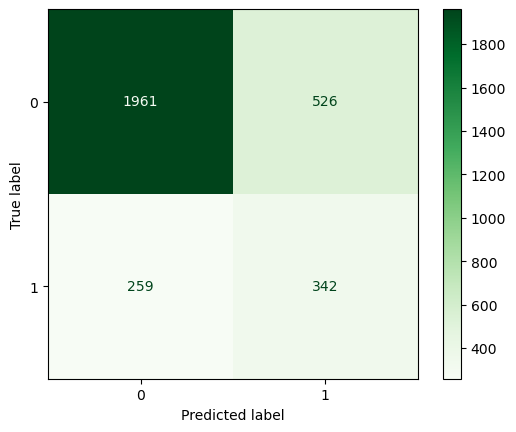

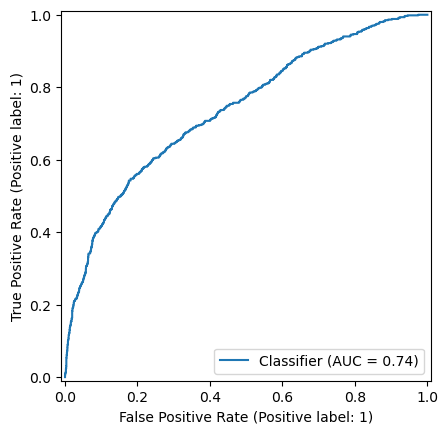

In [38]:
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap='Greens')
RocCurveDisplay.from_predictions(Y_test, Y_auc)